In [1]:
import os
import pandas as pd
import sys

sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.grad_RF_estim import fit_2dgauss, GAN_grad_RF_estimate
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr

KeyboardInterrupt: 

In [ ]:
# set up the experiment
from datetime import datetime
now = datetime.now()
date_time_str = now.strftime("%Y-%m-%d_%H-%M")


In [ ]:
refimgdir = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\data\data_sample"
exproot = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\results\result_real_%s" % date_time_str
os.makedirs(exproot, exist_ok=True)
score_methodlist = ["Chebyshev", "L1", "MSE", "cosine", "Correlation", "dot", "Spearman"]
population_size = [100,  200]
GAN_name = "fc6"
net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"

In [ ]:
refimgnms, refimgtsr = load_ref_imgs(
    imgdir=refimgdir, preprocess_type='resize', image_size=227)

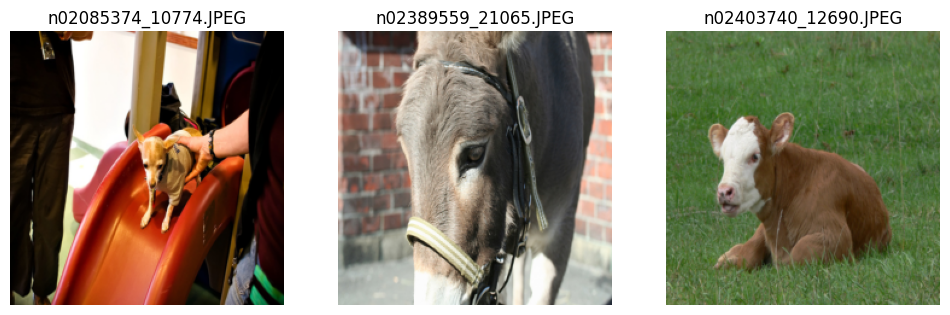

In [ ]:
# show three reference images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax[i].imshow(refimgtsr[i].permute(1, 2, 0))
    ax[i].set_title(refimgnms[i])
    ax[i].axis('off')

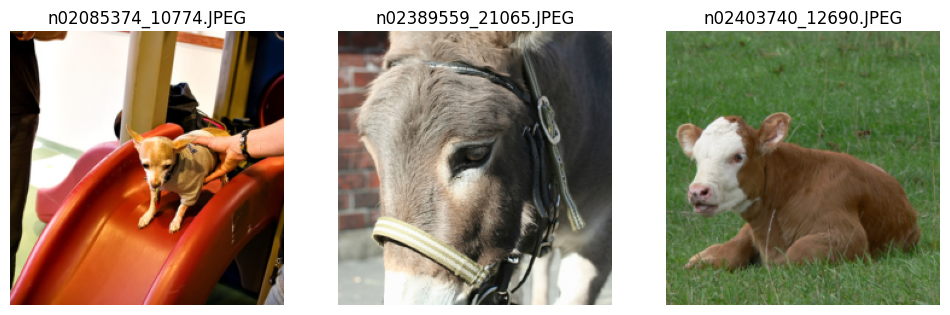

In [ ]:
refimgnms, refimgtsr = load_ref_imgs(
    imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
# show three reference images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax[i].imshow(refimgtsr[i].permute(1, 2, 0))
    ax[i].set_title(refimgnms[i])
    ax[i].axis('off')

In [ ]:
scorer = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(scorer.model, (3, 227, 227), "cuda", False)

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
G = upconvGAN(GAN_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

In [ ]:
# size and images used
target_gen_img_distance_df = pd.DataFrame(columns=["target_img", "score_method", "population_size",
                                                   "target_gen_img_distance"])
objective_score_df = pd.DataFrame(columns=["target_img", "score_method", "population_size", "objective_score"])

In [ ]:
# play with the population size
popsize = 150
expdir_pop = os.path.join(exproot, f"popsize-{popsize}")
os.makedirs(expdir_pop, exist_ok=True)


In [ ]:
scorer = TorchScorer(net_name)
unit_mask_dict, unit_tsridx_dict = set_random_population_recording(scorer, [layer_name], popsize=popsize)
# Encode a population of images to set the normalizer and mask.
ref_actmat, _ = encode_image(scorer, refimgtsr, key=layer_name,
                          RFresize=True, corner=(20, 20), imgsize=(187, 187))
popul_m, popul_s = set_normalizer(ref_actmat)
popul_mask = set_popul_mask(ref_actmat)


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
ref_actmat_ZS = (ref_actmat - popul_m) / popul_s
ref_act_mat_cov = np.cov(ref_actmat_ZS.T)

In [ ]:
# find PCA transformation of the reference population and transform the reference population to the PCA space and plot it plus the eigenvectors of the covariance matrix of the reference population in the PCA space and variance explained by each eigenvector
eigval, eigvec = np.linalg.eig(ref_act_mat_cov)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
eigval = eigval / np.sum(eigval)
eigval = np.sort(eigval)[::-1]
eigvec = eigvec[:, np.argsort(eigval)[::-1]]
ref_actmat_ZS_PCA = ref_actmat_ZS @ eigvec
#ploting the reference population in the PCA space
plt.figure()
plt.scatter(ref_actmat_ZS_PCA[:, 0], ref_actmat_ZS_PCA[:, 1], s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("reference population in the PCA space")
plt.show()
#ploting the variance explained by each eigenvector
plt.figure()
plt.plot(eigval)
plt.xlabel("eigenvector")
plt.ylabel("variance explained")
plt.title("variance explained by each eigenvector of the reference population covariance matrix")
plt.show()


In [ ]:
import os
import pandas as pd
import sys

sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.grad_RF_estim import fit_2dgauss, GAN_grad_RF_estimate
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
# set up the experiment
from datetime import datetime
now = datetime.now()
date_time_str = now.strftime("%Y-%m-%d_%H-%M")

refimgdir = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\data\data_sample_tiny"
exproot = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\results\result_real_%s" % date_time_str
os.makedirs(exproot, exist_ok=True)
score_methodlist = ["Chebyshev", "L1", "MSE", "cosine", "Correlation", "dot", "Spearman"]
population_size = [100, 150]
GAN_name = "fc6"
net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"

refimgnms, refimgtsr = load_ref_imgs(
    imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

scorer = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(scorer.model, (3, 227, 227), "cuda", False)
G = upconvGAN(GAN_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

# size and images used
target_gen_img_distance_df = pd.DataFrame(columns=["target_img", "score_method", "population_size",
                                                   "target_gen_img_distance"])
objective_score_df = pd.DataFrame(columns=["target_img", "score_method", "population_size", "objective_score"])

for popsize in population_size:
    #%% make a directory for the population size
    expdir_pop = os.path.join(exproot, f"popsize-{popsize}")
    os.makedirs(expdir_pop, exist_ok=True)
    #%% Set the population
    scorer = TorchScorer(net_name)
    unit_mask_dict, unit_tsridx_dict = set_random_population_recording(scorer, [layer_name], popsize=popsize)
    # Encode a population of images to set the normalizer and mask.
    ref_actmat, _ = encode_image(scorer, refimgtsr, key=layer_name,
                              RFresize=True, corner=(20, 20), imgsize=(187, 187))
    popul_m, popul_s = set_normalizer(ref_actmat)
    popul_mask = set_popul_mask(ref_actmat)

    #%% calculate the covariance matrix of the reference population
    ref_actmat_ZS = (ref_actmat - popul_m) / popul_s
    ref_act_mat_cov = np.cov(ref_actmat_ZS.T)

    #%% receptive field estimation
    unitslice = (unit_tsridx_dict[layer_name][0],
                 unit_tsridx_dict[layer_name][1][0],
                 unit_tsridx_dict[layer_name][2][0])
    gradAmpmap = GAN_grad_RF_estimate(G, scorer.model, layer_name, unitslice, input_size=(3, 227, 227),
                                  device="cuda", show=False, reps=100, batch=1)
    fitdict = fit_2dgauss(gradAmpmap, f"{net_name}-{popsize}-" + layer_short, outdir=expdir_pop, plot=True)

    #%% Run the evolution
    for imgid in range(1): #    range(len(refimgnms)):
        # Select target image and add target vector.
        targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
        targ_actmat, target_imgtsr_resized = encode_image(scorer, target_imgtsr, key=layer_name,
                                   RFresize=True, corner=(20, 20), imgsize=(187, 187))
        targlabel = os.path.splitext(targnm)[0]
        # organize data with the targetlabel
        expdir_img = os.path.join(expdir_pop, "rec_%s"%targlabel)
        os.makedirs(expdir_img, exist_ok=True)
        ToPILImage()(target_imgtsr_resized[0]).save(join(expdir_img, "targetimg.png"))
        #%% RF masking of the target image
        target_imgtsr_resized_RF_masked =\
            (torch.from_numpy(np.absolute(fitdict["fitmap"][None,:,:])) / fitdict["fitmap"].max()) *\
            target_imgtsr_resized
        ToPILImage()(target_imgtsr_resized_RF_masked[0]).save(join(expdir_img, "targetimg_RF_masked.png"))
        for score_method in ["cosine"]:
            expdir_meth = os.path.join(expdir_img, "method_%s" % score_method)
            os.makedirs(expdir_meth, exist_ok=True)
            explabel = "%s-%s-%s-popsize%d"%(targlabel, score_method, GAN_name, popsize)
            objfunc = set_objective(score_method, targ_actmat, popul_mask=None, popul_m=popul_m, popul_s=popul_s,
                                    VI=ref_act_mat_cov)
            optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                            init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                            maximize=True, random_seed=None, optim_params={})
            codes_all, scores_all, actmat_all, generations, RND, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
                run_evol(scorer, objfunc, optimizer, G, reckey=layer_name, label=explabel, savedir=expdir_meth,
                steps=50, RFresize=True, corner=(20, 20), imgsize=(187, 187), RF_mask=fitdict["fitmap"])
            figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat)
            figh.savefig(join(expdir_meth, "popul_act_evol_%s_%d.png" % (explabel, RND)))
            targe_gen_img_distance = get_image_distance_tensor(
                target_imgtsr_resized_RF_masked[0], last_gem_img_maske)
            # save the targe_gen_img_distance mean in the dataframe for each score method and population size AND image
            # used

            new_row = {"target_img": targlabel,
                       "score_method": score_method,
                       "population_size": popsize,
                       "target_gen_img_distance": targe_gen_img_distance.mean().item()}

            target_gen_img_distance_df = pd.concat(
                [target_gen_img_distance_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

            # save the objective score in the dataframe for each score method and population size AND image
            # used
            new_row = {"target_img": targlabel,
                        "score_method": score_method,
                        "population_size": popsize,
                        "objective_score": scores_all[-1]}
            objective_score_df = pd.concat(
                [objective_score_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

target_gen_img_distance_df.to_csv(
      os.path.join(exproot, f"target_gen_img_distance_df.cvs"), index=False)
objective_score_df.to_csv(
    os.path.join(exproot, f"objective_score_df.cvs"), index=False)


In [ ]:
import random
import math

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
 
#%% the asumptiopn is that element i of bost vector are coresponing to the same unit in the population. So we want find sub units that cause most the change in the cosine similarity
# we will use the falowing funtion to caculate the change in the cosine similarity for each unit ablation
def  unit_ablation_efect_on_similarity(v1, v2, unit_id):
    if unit_id >= len(v1):
        raise ValueError("unit_id is out of range")
    v1_ablated = np.delete(v1, unit_id)
    v2_ablated = np.delete(v2, unit_id)
    return cosine_similarity(v1, v2) - cosine_similarity(v1_ablated, v2_ablated)

# In the first hurstic we will rank all units with they efect on the cosine similarity and then we will select first 16 units that cause the most change in the cosine similarity

def select_sub_units(v1, v2, sub_population_size):
    unit_ids = np.arange(0, len(v1))
    unit_ids = sorted(unit_ids, key=lambda unit_id: unit_ablation_efect_on_similarity(v1, v2, unit_id), reverse=True)

    return unit_ids[:sub_population_size], unit_ids[-sub_population_size:]
def randnsphere(n):
  v = [random.gauss(0, 1) for i in range(0, n)]
  inv_len = 1.0 / math.sqrt(sum(coord * coord for coord in v))
  return np.array([coord * inv_len for coord in v])


best_rec_actmat = actmat_all[scores_all.argmax()]
targ_img_actmat = targ_actmat.squeeze()
most_similar_unit_idx, lest_similar_units_idx =select_sub_units(best_rec_actmat, targ_img_actmat, 32)
cosine_score = cosine_similarity(best_rec_actmat, targ_img_actmat)
print("cosine score: ", cosine_score)
print("most similar unit cosine score: ", cosine_similarity(best_rec_actmat[most_similar_unit_idx], targ_img_actmat[most_similar_unit_idx]))
print("lest similar unit cosine score: ", cosine_similarity(best_rec_actmat[lest_similar_units_idx], targ_img_actmat[lest_similar_units_idx]))

cosine score:  0.8900737
most similar unit cosine score:  0.9830097
lest similar unit cosine score:  0.51744473


In [ ]:
n = 16
# for the most similar units we will find the most similar images
most_similar_sub = os.path.join(expdir_meth, "most_n%d" % n)
os.makedirs(expdir_meth, exist_ok=True)
#%% Set the population
scorer_sub = TorchScorer(net_name)
flat_idx_samp = unit_mask_dict[layer_name][lest_similar_units_idx] # you can play here with the population 
scorer_sub.set_popul_recording(layer_name, flat_idx_samp, )


#%% receptive field estimation
unitslice_sub = (unit_tsridx_dict[layer_name][0][lest_similar_units_idx],
                unit_tsridx_dict[layer_name][1][0],
                unit_tsridx_dict[layer_name][2][0])
gradAmpmap_sub = GAN_grad_RF_estimate(G, scorer_sub.model, layer_name, unitslice, input_size=(3, 227, 227),
                                device="cuda", show=False, reps=100, batch=1)
fitdict_sub = fit_2dgauss(gradAmpmap_sub, f"{net_name}-{popsize}-" + layer_short, outdir=expdir_pop, plot=True)

targ_actmat_sub, _ = encode_image(scorer_sub, target_imgtsr, key=layer_name,
            RFresize=True, corner=(20, 20), imgsize=(187, 187))

objfunc_sub = set_objective(score_method, targ_actmat_sub, popul_mask=None, normalize = False)

optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
        init_code=np.zeros([1, code_length]), Aupdate_freq=10,
        maximize=True, random_seed=None, optim_params={})
        
codes_all_sub, scores_all_sub, actmat_all_sub, generations_sub, RND_sub, last_gem_img_sub,\
last_gem_img_maske_sub, best_imgs_sub, best_imgs_RF_masked_sub, best_scores_sub =\
    run_evol(scorer_sub, objfunc_sub, optimizer, G, reckey=layer_name, label=explabel, savedir=expdir_meth,
    steps=50, RFresize=True, corner=(20, 20), imgsize=(187, 187), RF_mask=fitdict_sub["fitmap"])


figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat_sub)
figh.savefig(join(expdir_meth, "popul_act_evol_%s_%d.png" % (explabel, RND)))
targe_gen_img_distance = get_image_distance_tensor(
    target_imgtsr_resized_RF_masked[0], last_gem_img_maske)
del scorer_sub

In [ ]:

def vec_similarity(v1, v2, similarty_metric=None):
    if similarty_metric is None:
        raise ValueError("similarty_metric is should be a function that caculate the similarity between two vectors")
    if similarty_metric == "cosine" or similarty_metric == "cosine_req":
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    elif similarty_metric == "MSE":
        # caculate the MSE between two vectors
        return -np.mean((v1 - v2) ** 2)
    
 
#%% the asumptiopn is that element i of bost vector are coresponing to the same unit in the population. So we want find sub units that cause most the change in the cosine similarity
# we will use the falowing funtion to caculate the change in the cosine similarity for each unit ablation
def  unit_ablation_efect_on_similarity(v1, v2, unit_id, similarty_metric=None):
    if unit_id >= len(v1):
        raise ValueError("unit_id is out of range")
    if similarty_metric is None:
        raise ValueError("similarty_metric is should be a function that caculate the similarity between two vectors")
    v1_ablated = np.delete(v1, unit_id)
    v2_ablated = np.delete(v2, unit_id)
    return vec_similarity(v1, v2, similarty_metric) -\
            vec_similarity(v1_ablated, v2_ablated, similarty_metric)


# In the first hurstic we will rank all units with they efect on the cosine similarity and then we will select first 16 units that cause the most change in the cosine similarity

def select_sub_units(v1, v2, sub_population_size, similarty_metric=None):
    if sub_population_size > len(v1):
        raise ValueError("sub_population_size is bigger than the population size")
    if similarty_metric is None:
        raise ValueError("similarty_metric is should be a function that caculate the similarity between two vectors")
    unit_ids = np.arange(0, len(v1))
    # sort units by their effect on the similarity matric
    unit_ids = sorted(unit_ids, key=lambda unit_id: unit_ablation_efect_on_similarity(v1, v2, unit_id, similarty_metric), reverse=True)
    # lest return the best and the worst and random selection of units
    return unit_ids[:sub_population_size], unit_ids[-sub_population_size:], np.random.choice(unit_ids, sub_population_size, replace=False)
def randnsphere(n):
  v = [random.gauss(0, 1) for i in range(0, n)]
  inv_len = 1.0 / math.sqrt(sum(coord * coord for coord in v))
  return np.array([coord * inv_len for coord in v])
# two random vectors
#v1 = actmat_all[scores_all.argmax()]
#v2 = targ_actmat.squeeze()
v1 = randnsphere(150)
v2 = randnsphere(150)
sub_population_size = 32
similarty_metric = "cosine"
sub_pop_dict = dict()
sub_pop_dict["best"], sub_pop_dict["worst"], sub_pop_dict["random"]  = select_sub_units(v1, v2, sub_population_size, similarty_metric)
print("similarity score: ", vec_similarity(v1, v2, similarty_metric))
for sub_pop_type, sub_units in sub_pop_dict.items():  
    print(f"{sub_pop_type} similar unit cosine score: ", vec_similarity(v1[sub_units], v2[sub_units], similarty_metric))

similarity score:  -0.09673203805460344
best similar unit cosine score:  0.704580254255131
worst similar unit cosine score:  -0.8866016315728065
random similar unit cosine score:  -0.0418806855457152


In [ ]:
for subpopsize in [2**i for i in range(1, int(np.log2(popsize/2))+1)]:
    print("subpopsize: %d"%subpopsize)
    # select sub populations
    sub_pop_dict = dict()
    best_rec_actmat = actmat_all[scores_all.argmax()]
    targ_img_actmat = targ_actmat.squeeze()

    sub_pop_dict["best"], sub_pop_dict["worst"], sub_pop_dict["random"] = \
            select_sub_units(best_rec_actmat, targ_img_actmat, \
                            subpopsize, score_method)
    for sub_pop_type, sub_units in sub_pop_dict.items():
        print("sub_pop_type: %s"%sub_pop_type)
        print("sub_units: ", unit_mask_dict[layer_name][sub_units])
        # set new dictionary for the sub population

subpopsize: 2
sub_pop_type: best
sub_units:  [  253 32194]
sub_pop_type: worst
sub_units:  [39123 22730]
sub_pop_type: random
sub_units:  [36419 17829]
subpopsize: 4
sub_pop_type: best
sub_units:  [  253 32194 40982  9886]
sub_pop_type: worst
sub_units:  [23913  5830 39123 22730]
sub_pop_type: random
sub_units:  [ 1605  7858 25772  1267]
subpopsize: 8
sub_pop_type: best
sub_units:  [  253 32194 40982  9886 14618 22223  1605 15632]
sub_pop_type: worst
sub_units:  [17829 15463 36419 37264 23913  5830 39123 22730]
sub_pop_type: random
sub_units:  [34898 21209 26955 42672 38785 41827 12083 25265]
subpopsize: 16
sub_pop_type: best
sub_units:  [  253 32194 40982  9886 14618 22223  1605 15632 11914 20702 16139 23237
 27631 20195 41827 25772]
sub_pop_type: worst
sub_units:  [ 1943  6168 33546 32025 34222 24251  4647 20364 17829 15463 36419 37264
 23913  5830 39123 22730]
sub_pop_type: random
sub_units:  [32363 26279 33715 38616  1943   253 21209 36419 37264 35743 26955 34560
 28476 19181  8196

In [ ]:
result_log_df = pd.DataFrame(columns=["output_type", "trget_imge_id", "similarity_metric", "pop_size", "pop_resample_id",
                                       "gan_name", "layer_name", "layer_short", "net_name", "img_size", "pading_size", "input_size",
                                       "gen_rerun_id", "sub_pop_type", "sub_pop_size", "sub_pop_re_run_id", "save_dir_root", "file_name"])
# I have result_log_df to save log of any file that is saved. No I want a funtion get a tensoer and this data fram and save the tensor and add a row to the data frame
# the index of the data frame is the file name which is caculated by a function that generate random string (i.e., get file name). 
# the function should also save the tensor in the save_dir_root with generated file name. Function input is the tensor and the data frame and a param dict that contain some of the data frame columns but
# not all of them. For coulum that are not in the param dict, the function should use the get them in a **kwargs format. And if the colums is not determine with **kwargs or param dict, it should be None.
# the function should return the data frame with the new row added to it.

def get_a_file_name():
    timestamp = int(time.time())
    random_value = np.random.randint(1E7)
    return f"{timestamp}_{random_value}"

def print_tensor(imtsr, save_dir_root, df, **kwargs):
    file_name = get_a_file_name()
    ToPILImage()(imtsr).save(join(save_dir_root, f"{file_name}.png"))
    new_row = list()
    for column_name in df.columns:
        if column_name not in kwargs:
            kwargs[column_name] = None
        new_row.append(kwargs[column_name])
    df.loc[file_name] = new_row

net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"
gan_name = "fc6"
pop_size = [2, 4, 8, 16, 32, 64, 128, 195, 256]
metric_name = ["cosine", "MSE"]
input_size = (3, 227, 227)
img_size = (187, 187)
pading_size = (20, 20) 
param_dict = {"net_name": net_name,
                    "layer_name": layer_name,
                    "layer_short": layer_short,
                    "gan_name": gan_name,
                    "pop_size": pop_size,
                    "metric_name": metric_name,
                    "input_size": input_size,
                    "img_size": img_size,
                    "pading_size": pading_size}
print_tensor(target_imgtsr_resized[0], exproot, result_log_df,  pop_resample_id=10, **param_dict)
result_log_df.head()


,output_type,trget_imge_id,similarity_metric,pop_size,pop_resample_id,gan_name,layer_name,layer_short,net_name,img_size,pading_size,input_size,gen_rerun_id,sub_pop_type,sub_pop_size,sub_pop_re_run_id,save_dir_root,file_name
1685060322_6601811,None,None,None,"[2, 4, 8, 16, 32, 64, 128, 195, 256]",10,fc6,.features.Conv2d10,conv5,alexnet,"(187, 187)","(20, 20)","(3, 227, 227)",None,None,None,None,None,None


In [ ]:
titlestr = "asdfdsaf"
best_scores = 23243
print("%s evol finished! best score: %.3f"%(titlestr, best_scores))

asdfdsaf evol finished! best score: 23243.000


In [ ]:
import os
import pandas as pd
import sys

sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.grad_RF_estim import fit_2dgauss, GAN_grad_RF_estimate
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
# set up the experiment
from datetime import datetime
now = datetime.now()
date_time_str = now.strftime("%Y-%m-%d_%H-%M")

refimgdir = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\data\data_sample_tiny"
exproot = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\results\result_real_%s" % date_time_str
os.makedirs(exproot, exist_ok=True)
score_methodlist = ["Chebyshev", "L1", "MSE", "cosine", "Correlation", "dot", "Spearman"]
population_size = [100, 150]
GAN_name = "fc6"
net_name = "alexnet"
layer_name = ".features.Conv2d10"
layer_short = "conv5"
expriment_meta_data_df = pd.DataFrame(columns=["output_type", "trget_imge_name", "similarity_metric", "pop_size", "pop_resampling_id",
                                       "gan_name", "layer_name", "layer_short", "net_name", "img_size", "pading_size", "input_size", "score","pop_unit_idx",
                                       "gen_rerun_id", "sub_pop_type", "sub_pop_size", "sub_pop_re_run_id", "save_dir_root", "file_name"])
expriment_meta_data_df.to_hdf(os.path.join(exproot, "expriment_meta_data_df.h5"), key="expriment_meta_data_df", mode="w")


In [ ]:
PILimage = True
if not PILimage:
        print("not PILimage")

In [2]:
#%% 
# Importing libraries 
from datetime import datetime
import os
import pandas as pd
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this
#%%
# parameters parsing
# 
NUM_OF_RUNS_PER_POP_SIZE = 1
NUM_OF_RUNS_PER_IMAGE = 1
NUM_OF_RUN_RER_SUBPOAP = 1

#%%
# set main fynction
if __name__=="__main__":
    #%%
    #import datetime
    now = datetime.now()
    from core.utils.GAN_utils import upconvGAN
    from core.utils.Optimizers import CholeskyCMAES
    from core.utils.grad_RF_estim import fit_2dgauss, GAN_grad_RF_estimate
    from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
    #%% 
    # Set parameters
    date_time_str = now.strftime("%Y-%m-%d_%H-%M")
    refimgdir = r"C:\Data\cosine\insilico_experiments\papulation_size_effect\data\data_sample_tiny"
    exp_result_root = r"C:\Data\cosine\insilico_experiments\sub_pop_reconstraction\results\tiny_bach_%s" % date_time_str
    os.makedirs(exp_result_root, exist_ok=True)

    net_name = "alexnet"
    layer_name = ".features.Conv2d10"
    layer_short = "conv5"
    gan_name = "fc6"
    pop_size = [4]
    metric_name = ["cosine"]
    input_size = (3, 227, 227)
    img_size = (187, 187)
    pading_size = (20, 20) 
    #%% make a dictionary of the parameters
    param_dict = {"net_name": net_name,
                    "layer_name": layer_name,
                    "layer_short": layer_short,
                    "gan_name": gan_name,
                    "pop_size": pop_size,
                    "input_size": input_size,
                    "pading_size": pading_size}
    trial_param_dict = param_dict.copy()
    #%% set up a pandas dataframe to save the inforamtions about each run
    expriment_meta_data_df = pd.DataFrame(columns=["output_type", "trget_imge_name", "similarity_metric", "pop_size", "pop_resampling_id", "score",
                                       "gan_name", "layer_name", "layer_short", "net_name", "img_size", "pading_size", "input_size", "score","pop_unit_idx",
                                       "gen_rerun_id", "sub_pop_type", "sub_pop_size", "sub_pop_re_run_id", "save_dir_root", "file_name"])

    #%% save the parameters
    #%% Load the reference images
    refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
    #%% Set up the scorer and the population
    scorer = TorchScorer(net_name)
    module_names, module_types, module_spec = get_module_names(
        scorer.model, input_size, "cuda", False)

    # %% set up the GAN
    G = upconvGAN(gan_name).cuda()
    G.requires_grad_(False)
    code_length = G.codelen

    #%% Run the experiment
    scorer = TorchScorer(net_name)
    for popsize in pop_size:
        #%% add the population size to the dictionary
        trial_param_dict = param_dict.copy()
        trial_param_dict["pop_size"] = popsize
        trial_param_dict["sub_pop_type"] = "whole"
        #%% Set the population
        for pop_resampling_id in range(NUM_OF_RUNS_PER_POP_SIZE):
            # add the population resampling id to the dictionary
            trial_param_dict["pop_resampling_id"] = pop_resampling_id
            # Set scorer and select population    
            
            unit_mask_dict, unit_tsridx_dict = set_random_population_recording(
                scorer, [layer_name], popsize=popsize, seed=pop_resampling_id)
            ## add the population unit index to the dictionary
            trial_param_dict["pop_unit_idx"] = unit_mask_dict[layer_name]
            # Encode a population of images to set the normalizer and mask.
            ref_actmat, _ = encode_image(scorer, refimgtsr, key=layer_name,
                                    RFresize=True, corner=pading_size, imgsize=img_size)
            popul_m, popul_s = set_normalizer(ref_actmat)
            popul_mask = set_popul_mask(ref_actmat)
            # receptive field estimation
            unitslice = (unit_tsridx_dict[layer_name][0],
                        unit_tsridx_dict[layer_name][1][0],
                        unit_tsridx_dict[layer_name][2][0])
            gradAmpmap = GAN_grad_RF_estimate(G, scorer.model, layer_name, unitslice, input_size=input_size,
                                        device="cuda", show=False, reps=100, batch=1)
            fitdict = fit_2dgauss(gradAmpmap)
            #%% Run the evolution
            for imgid in range(1):
                # Select target image and add target vector.
                targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
                targ_actmat, target_imgtsr_resized = encode_image(scorer, target_imgtsr, key=layer_name,
                                        RFresize=True, corner=pading_size, imgsize=img_size)
                targlabel = os.path.splitext(targnm)[0]
                # add the target image name to the dictionary
                trial_param_dict["trget_imge_name"] = targlabel
                #%% save the target\masked image
                print_tensor(target_imgtsr_resized[0], exp_result_root, expriment_meta_data_df, output_type="target_img", **trial_param_dict)

                target_imgtsr_resized_RF_masked =\
                    (torch.from_numpy(np.absolute(fitdict["fitmap"][None,:,:])) / fitdict["fitmap"].max()) *\
                    target_imgtsr_resized
                print_tensor(target_imgtsr_resized_RF_masked[0], exp_result_root, expriment_meta_data_df, output_type="target_img_RF_masked", **trial_param_dict)
                
                for score_method in metric_name:
                    ## add the similarity metric to the dictionary
                    trial_param_dict["similarity_metric"] = score_method
                    for gen_rerun_id in range(NUM_OF_RUNS_PER_IMAGE):
                        ## add the generation re-run id to the dictionary
                        trial_param_dict["gen_rerun_id"] = gen_rerun_id
                        ## set fig title 
                        title_str = "%s-%s-%s-popsize%d"%(trial_param_dict["trget_imge_name"],
                                                trial_param_dict["similarity_metric"], trial_param_dict["gan_name"],
                                                trial_param_dict["pop_size"])
                        #set objective function
                        objfunc = set_objective(score_method, targ_actmat, popul_mask=None, popul_m=popul_m,
                                                popul_s=popul_s)
                        ## set optimizer
                        optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                                        init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                                        maximize=True, random_seed=None, optim_params={})
                        print("------flag1------")
                        codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
                            run_evol(scorer, objfunc, optimizer, G, reckey=layer_name, savedir=exp_result_root, meta_data_df=expriment_meta_data_df, trial_param_dict=trial_param_dict,
                            titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict["fitmap"], save_plot="full")
                        print("------flag2------")
                        # 
                        figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
                        print_fig(figh, exp_result_root, expriment_meta_data_df, output_type= "popul_act_evol",**trial_param_dict)
                        plt.close("all")
                        # sub population analysis
                        # loop ovet the all popolations sizes which is less than popsize/2 and are a power of 2
                        scorer_sub = TorchScorer(net_name)

            scorer.cleanup()
            #del optimizer, objfunc, gradAmpmap, fitdict, targ_actmat, trial_param_dict
            torch.cuda.empty_cache() 
                

Layer .features.Conv2d10 Sampled 4 units from feature tensor of shape (256, 13, 13)
4  units still active in the mask.
Gaussian Fitting center (109.2, 111.4)
 Cov mat XX 842.6 YY 795.1 XY -5.7
Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
------flag1------
:-------------------->  n08524735_17105-cosine-fc6-popsize4 evol finished! best score: 1.000
------flag2------
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [28]:
len(best_imgs)

100

In [29]:
RF_mask =fitdict["fitmap"]
best_imgs_RF_masked = []
for i in range(len(best_imgs)):
    best_imgs_RF_masked.append(torch.from_numpy(np.absolute(RF_mask[None,:,:]) / RF_mask.max()) * best_imgs[i])
#from core.utils.plot_utils import show_imgrid
#show_imgrid(mtg_exp_RF_masked)




In [18]:
torch.convert_to_tensor(np.absolute(RF_mask[None,:,:]) / RF_mask.max())* best_imgs[i]

AttributeError: module 'torch' has no attribute 'convert_to_tensor'

In [8]:
mtg_exp_RF_masked = ToPILImage()(make_grid(best_imgs_RF_masked, nrow=10))

In [9]:
last_gen_masked = (torch.from_numpy(np.absolute(RF_mask[None,None,:,:])) / RF_mask.max()) * last_gem_img


In [10]:
mtg_RF_masked = ToPILImage()(make_grid(last_gen_masked, nrow=7))
last_gen_masked_mean = torch.mean(last_gen_masked, dim=0)

In [ ]:
# read the pandas data frame that contain that save like this expriment_meta_data_df.to_hdf(os.path.join(exp_result_root, "expriment_meta_data_df.h5"), key="expriment_meta_data_df", mode="w")
import pandas as pd
exp_result_root = r"C:\Data\cosine\insilico_experiments\sub_pop_reconstraction\results\tiny_bach_2023-05-29_19-09"
expriment_meta_data_df = pd.read_hdf(os.path.join(exp_result_root, "expriment_meta_data_df.h5"), key="expriment_meta_data_df")
expriment_meta_data_df

,output_type,trget_imge_name,similarity_metric,pop_size,pop_resampling_id,gan_name,layer_name,layer_short,net_name,img_size,pading_size,input_size,score,pop_unit_idx,gen_rerun_id,sub_pop_type,sub_pop_size,sub_pop_re_run_id,save_dir_root,file_name
1685401782_5444696,target_img,n08524735_17105,None,2,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[14111, 26786]",None,whole,None,None,None,None
1685401782_3340520,target_img_RF_masked,n08524735_17105,None,2,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[14111, 26786]",None,whole,None,None,None,None
1685401796_8050211,best_gen_imgs,n08524735_17105,cosine,2,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",1.000000,"[14111, 26786]",0,whole,None,None,None,None
1685401796_3244256,best_gen_imgs_RF_masked,n08524735_17105,cosine,2,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",1.000000,"[14111, 26786]",0,whole,None,None,None,None
1685401796_1343255,last_gen_mean_imgs,n08524735_17105,cosine,2,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",0.999974,"[14111, 26786]",0,whole,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685404215_8634568,best_in_each_gen_imgs,n09637339_1388,MSE,32,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[31856, 12421]",0,random,2,None,None,None
1685404215_823603,last_gen_all_imgs_RF_masked,n09637339_1388,MSE,32,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",-0.212862,"[31856, 12421]",0,random,2,None,None,None
1685404215_265418,best_in_each_gen_imgs_RF_masked,n09637339_1388,MSE,32,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",NaN,"[31856, 12421]",0,random,2,None,None,None
1685404215_6311788,optimization_trajectory,n09637339_1388,MSE,32,0,fc6,.features.Conv2d10,conv5,alexnet,None,"(20, 20)","(3, 227, 227)",-0.212862,"[31856, 12421]",0,random,2,None,None,None


In [ ]:
type(expriment_meta_data_df["gen_rerun_id"][1])


NoneType